# 0 - Utilities and imports

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from data_analysis import *


# 1 - Data load

Dataset Shape: (600, 8)



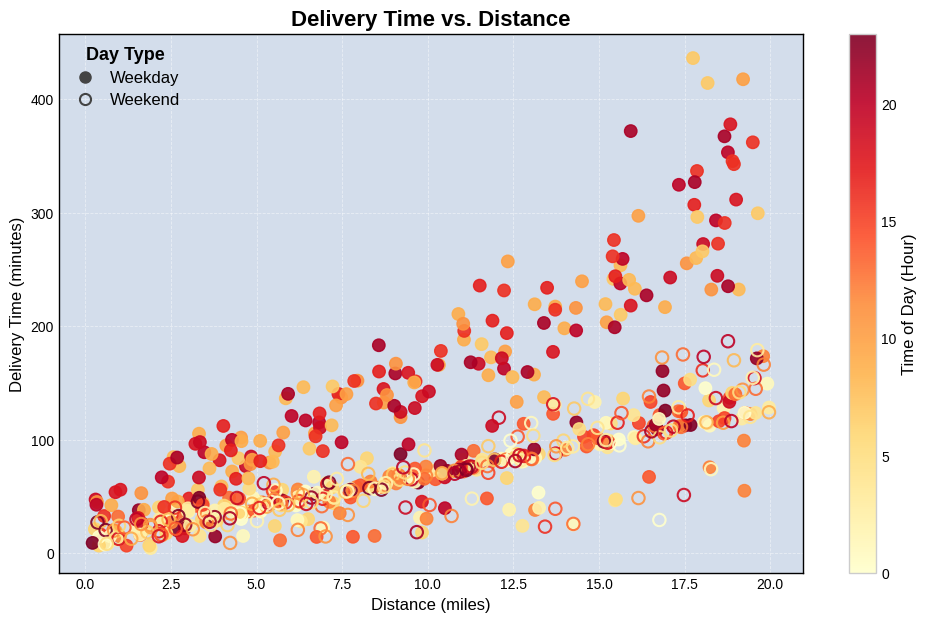

In [2]:
# file_path = './data/delivery_data_rush_noise.csv'
file_path = './data/delivery_data_rush_noise_curve.csv'
# file_path = './data/delivery_data_rush_noise_curve_extended.csv'
# file_path = './data/delivery_data_rush_noise_curve_smaller_gap_extended.csv'
# file_path = './data/delivery_data_rush_noise_curve_smaller_gap.csv'

data_df = pd.read_csv(file_path)

print(f"Dataset Shape: {data_df.shape}\n")

plot_delivery_data(data_df)

## 1.1 Analysis

=== Summary Statistics ===
       distance_miles  package_weight_lb   num_items  delivery_hour  \
count      600.000000         600.000000  600.000000     600.000000   
mean         9.754146          20.712892    7.425000      11.265000   
std          5.680250          11.354086    3.960284       6.809213   
min          0.213477           1.050897    1.000000       0.000000   
25%          4.837271          10.636829    4.000000       5.000000   
50%          9.470223          20.358675    7.000000      12.000000   
75%         14.722327          30.687378   11.000000      17.000000   
max         19.964584          39.989536   14.000000      23.000000   

       delivery_on_weekend  delivery_time_min   tip_given    is_heavy  \
count           600.000000         600.000000  600.000000  600.000000   
mean              0.308333          96.204661    0.371667    0.510000   
std               0.462190          74.482814    0.483653    0.500317   
min               0.000000           4.54

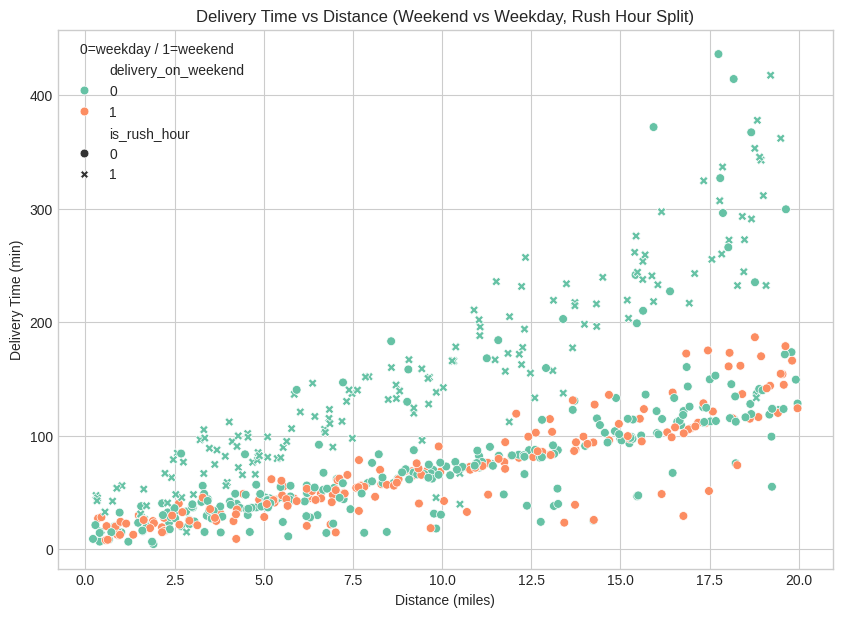

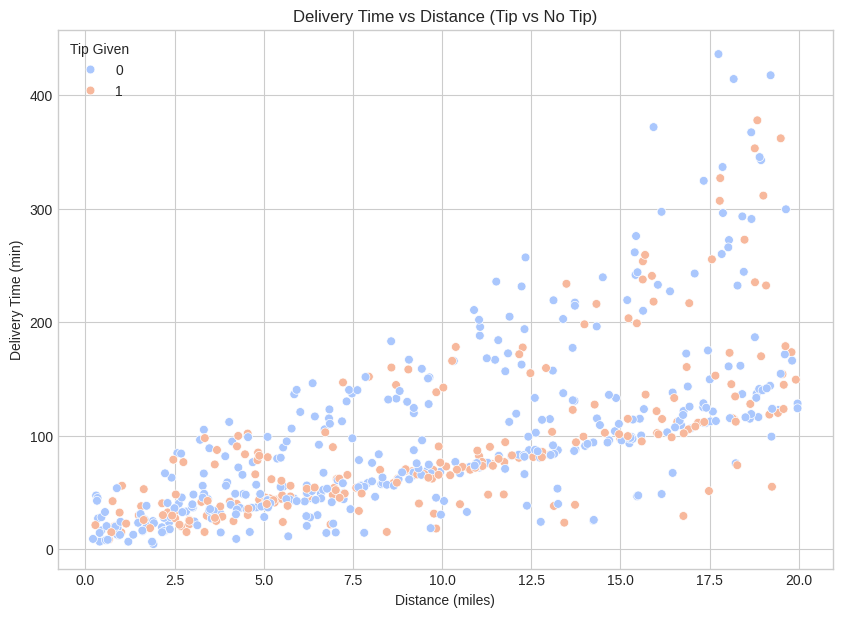

/home/nucleusfox/Thor/deep_learning/delivery_time/data_analysis.py:630: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="is_heavy", y="delivery_time_min", palette="viridis")


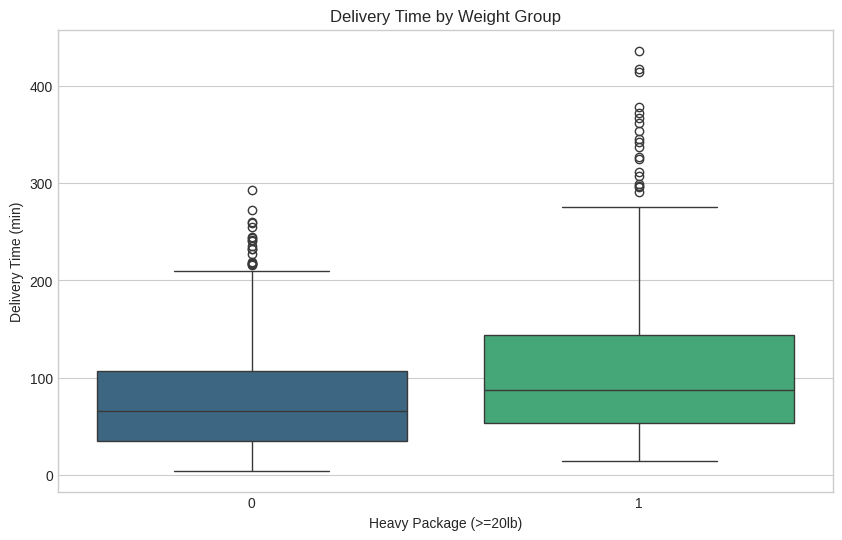

/home/nucleusfox/Thor/deep_learning/delivery_time/data_analysis.py:638: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="is_big_package", y="delivery_time_min", palette="viridis")


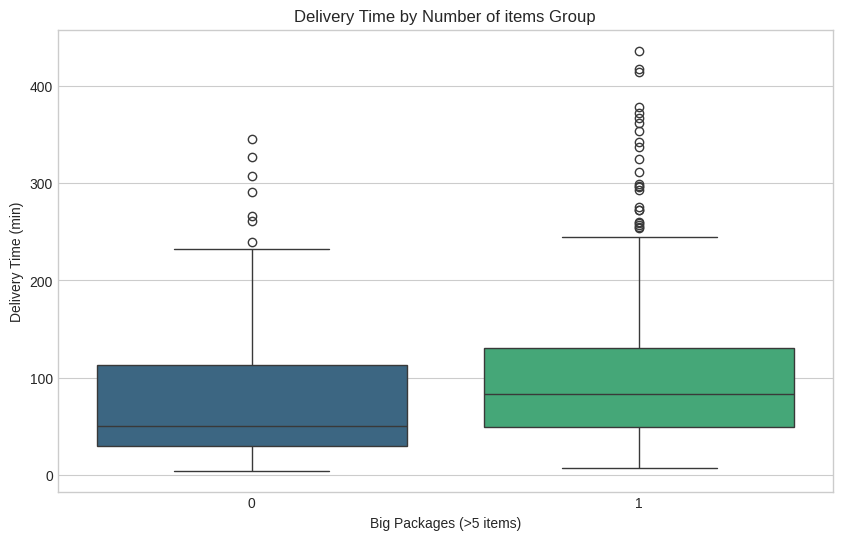

/home/nucleusfox/Thor/deep_learning/delivery_time/data_analysis.py:648: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x="package_combo", y="delivery_time_min", palette="viridis")


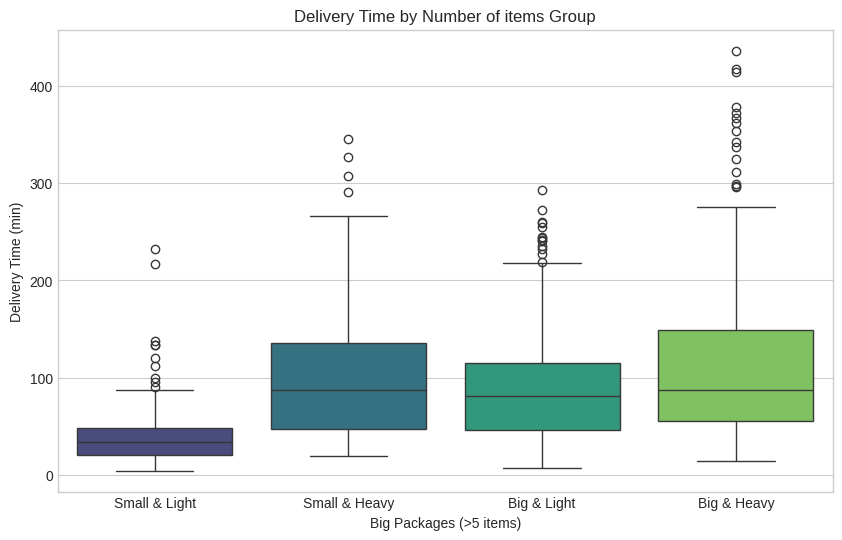

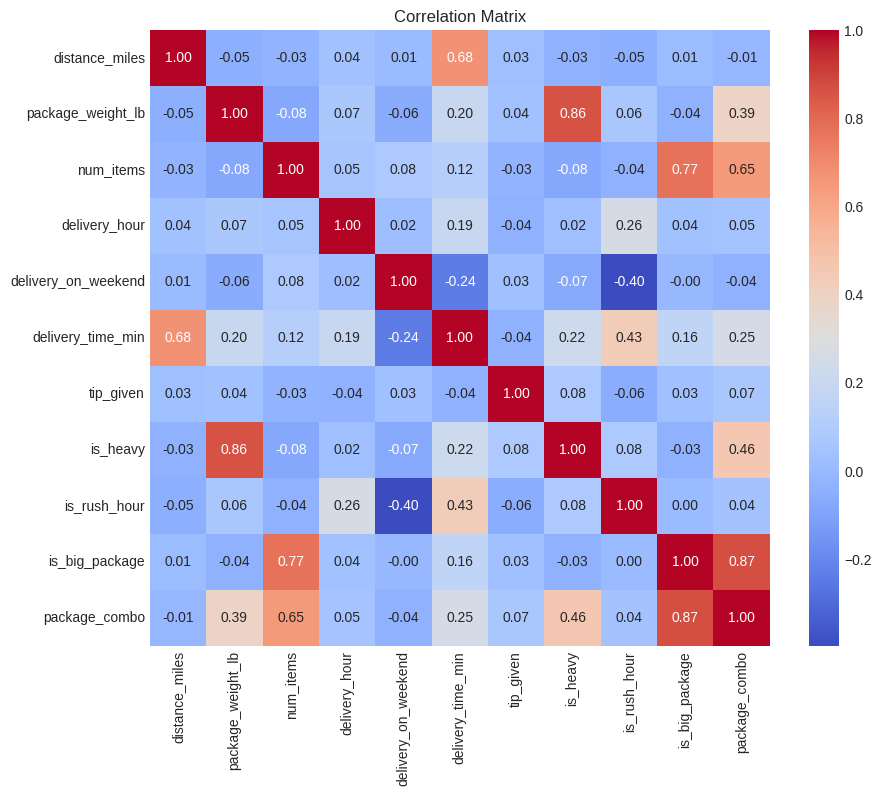

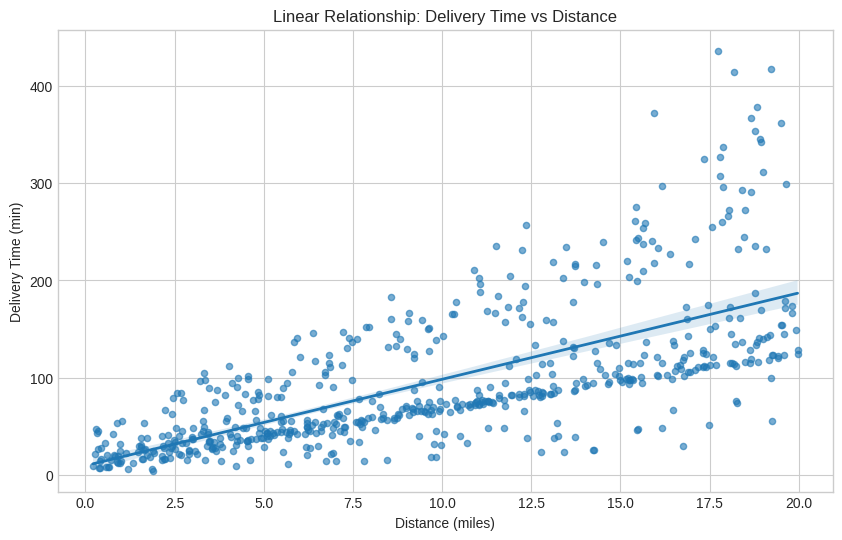

In [3]:
loaded_data = load_delivery_data(path=file_path)

print("=== Summary Statistics ===")
print(summary_stats(loaded_data))

print("\n=== Weekend vs Weekday Statistics ===")
print(weekend_vs_weekday_stats(loaded_data))

print("\n=== Tip Effect Statistics ===")
print(tip_effect_stats(loaded_data))

print("\n=== Rush Hour Effect Statistics ===")
print(rush_hour_effect_stats(loaded_data))

print("\n=== Weight Group Statistics ===")
print(weight_group_stats(loaded_data))

print("\n=== Correlation Table ===")
print(correlation_table(loaded_data))

print("\n=== Plots === ")
plot_time_vs_distance_weekend(loaded_data)
plot_time_vs_distance_tip(loaded_data)
boxplot_time_by_weight(loaded_data)
boxplot_time_by_number(loaded_data)
boxplot_time_by_package_combo(loaded_data)
correlation_heatmap(loaded_data)
plot_distance_time_regression(loaded_data)


## 1.2 Data Preparation

In [4]:
def robust_scale(x):
    """
    Robust-scaling for a 1D torch tensor.
    """
    median = x.median()
    q1 = x.kthvalue(int(0.25 * len(x)))[0]
    q3 = x.kthvalue(int(0.75 * len(x)))[0]
    iqr = q3 - q1

    if iqr == 0:
        iqr = torch.tensor(1e-8, device=x.device)

    x_scaled = (x - median) / iqr

    scaler = {
        "median": median,
        "iqr": iqr
    }

    return x_scaled, scaler


def apply_robust_scale(x, scaler):
    median = scaler["median"]
    iqr = scaler["iqr"]

    return (x - median) / iqr

def robust_descale(x_scaled, scaler):
    """
    Invert robust scaling to return the values to original scale.
    """
    median = scaler["median"]
    iqr = scaler["iqr"]

    return x_scaled * iqr + median


def prepare_data(df):
    """
    Converts a pandas DataFrame into prepared PyTorch tensors for modeling.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing the raw delivery data.

    Returns:
        prepared_features (torch.Tensor): The final 2D feature tensor for the model.
        prepared_targets (torch.Tensor): The final 2D target tensor.
        results_dict (dict): A dictionary of intermediate tensors for testing purposes.
    """
    
    all_values = df.values
    full_tensor = torch.from_numpy(df.to_numpy().astype(np.float32))
    
    # columns:
    # 0 distance_miles,
    # 1 package_weight_lb,
    # 2 num_items,
    # 3 delivery_hour,
    # 4 delivery_on_weekend,
    # 5 delivery_time_min,
    # 6 tip_given

    # Filter by distance
    raw_distances = full_tensor[:, 0]
    raw_weight = full_tensor[:, 1]
    raw_num_items = full_tensor[:, 2]
    raw_delivery_hour = full_tensor[:, 3]
    raw_delivery_on_weekend = full_tensor[:, 4]
    raw_targets = full_tensor[:, 5]
    raw_tip_given = full_tensor[:, 6]

    # Engineer new simpler features
    is_rush_hour_feature = (raw_delivery_on_weekend == 0 & ((raw_delivery_hour >= 8) & (raw_delivery_hour < 11) | (raw_delivery_hour >= 16) & (raw_delivery_hour < 20))).float()
    is_heavy_feature = (raw_weight > 20).float()

    distances_col = raw_distances.unsqueeze(1)
    num_items_col = raw_num_items.unsqueeze(1)
    hours_col = raw_delivery_hour.unsqueeze(1)
    weekends_col = raw_delivery_on_weekend.unsqueeze(1)
    rush_hour_col = is_rush_hour_feature.unsqueeze(1)
    heavy_package_col = is_heavy_feature.unsqueeze(1)
    tipped_col = raw_tip_given.unsqueeze(1)
    targets_col = raw_targets.unsqueeze(1)

    # Normalize continuous and large feature columns
    dist_scaled, dist_scaler = robust_scale(raw_distances)
    target_scaled, target_scaler = robust_scale(raw_targets)
    
    distances_norm = dist_scaled.unsqueeze(1)
    targets_norm = target_scaled.unsqueeze(1)
    
    
    # dist_mean, dist_std = distances_col.mean(), distances_col.std()
    # targets_mean, targets_std = targets_col.mean(), targets_col.std()
    hours_mean, hours_std = hours_col.mean(), hours_col.std()
    num_items_mean, num_items_std = num_items_col.mean(), num_items_col.std()
 
    # distances_norm = (distances_col - dist_mean) / dist_std
    # targets_norm = (targets_col - targets_mean) / targets_std
    
    hours_norm = (hours_col - hours_mean) / hours_std
    num_items_norm = (num_items_col - num_items_mean) / num_items_std

    # Combine all
    prepared_features = torch.cat([
        distances_norm,
        heavy_package_col,
        num_items_norm,
        hours_norm,
        weekends_col,
        rush_hour_col,
        tipped_col
    ], dim=1)

    prepared_targets = targets_norm
    
    # Dictionary for testing
    results_dict = {
        'full_tensor': full_tensor,
        'raw_distances': raw_distances,
        'raw_weight': raw_weight,
        # 'raw_num_items': raw_num_items,
        'raw_delivery_hour': raw_delivery_hour,
        'raw_delivery_on_weekend': raw_delivery_on_weekend,
        'raw_targets': raw_targets,
        # 'raw_tip_given': raw_tip_given,
        'distances_col': distances_col,
        'heavy_package_col': heavy_package_col,
        'num_items_col': num_items_col,
        'hours_col': hours_col,
        'weekends_col': weekends_col,
        'rush_hour_col': rush_hour_col,
        # 'tipped_col': tipped_col,
        'dist_scaler': dist_scaler,
        'target_scaler': target_scaler,
        'features': prepared_features
    }
    
    return prepared_features, prepared_targets, results_dict

def denormalize_predictions(df, predicted_outputs):
    all_values = df.values
    full_tensor = torch.from_numpy(df.to_numpy().astype(np.float32))
    raw_targets = full_tensor[:, 5]
    targets_col = raw_targets.unsqueeze(1)
    targets_mean, targets_std = targets_col.mean(), targets_col.std()
    
    predicted_outputs_denormalized = predicted_outputs * targets_std + targets_mean
    
    return predicted_outputs_denormalized

# Because data is very noisy and have extreme outliers
data_df = data_df[data_df["delivery_time_min"] < data_df["delivery_time_min"].quantile(0.98)]

features, targets, results_dict = prepare_data(data_df)

# 2 - Neural Network Architecture

In [5]:
def init_model(num_of_input = 7):
    """
    Initializes the neural network model, optimizer, and loss function.

    Returns:
        model (nn.Sequential): The initialized PyTorch sequential model.
        optimizer (torch.optim.Optimizer): The initialized optimizer for training.
        loss_function: The initialized loss function.
    """

    torch.manual_seed(42)

    model = nn.Sequential(
        nn.Linear(num_of_input, 8),
        # nn.SiLU(),
        # nn.GELU(),
        nn.Softplus(),
        nn.Dropout(0.05),
        nn.Linear(8, 1),
    ) 
    # optimizer = optim.SGD(model.parameters(), lr=0.005)
    optimizer = optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-5)
    # loss_function = nn.MSELoss()
    loss_function = nn.SmoothL1Loss()
    # loss_function = smooth_mse_loss

    return model, optimizer, loss_function


# 3 - Train

In [16]:
def train_model(features, targets, epochs, verbose=True):
    """
    Trains the model using the provided data for a number of epochs.
    
    Args:
        features (torch.Tensor): The input features for training.
        targets (torch.Tensor): The target values for training.
        epochs (int): The number of training epochs.
        verbose (bool): If True, prints training progress. Defaults to True.
        
    Returns:
        model (nn.Sequential): The trained model.
        losses (list): A list of loss values recorded every 5000 epochs.
    """
    
    losses = []
    num_of_features = features.shape[1]
    model, optimizer, loss_function = init_model(num_of_features)
    model.train()
    distances = features[:, 0].unsqueeze(1)

    for epoch in range(epochs):
        outputs = model(features)
        loss = loss_function(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % step == 0:
            losses.append(loss.item())
            if verbose:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    return model, losses

features_selected = features[:, [0, 1, 3, 5]] # distance, heavy package, delivery hour, rush hour

print(f"Features selected shape: {features_selected.shape}")
print(f"Targets shape: {targets.shape}")

epochs = 80000
step = 10000
model, loss = train_model(features_selected, targets, epochs, step)

Features selected shape: torch.Size([588, 4])
Targets shape: torch.Size([588, 1])
Epoch [10000/80000], Loss: 0.2704
Epoch [20000/80000], Loss: 0.2290
Epoch [30000/80000], Loss: 0.2039
Epoch [40000/80000], Loss: 0.1761
Epoch [50000/80000], Loss: 0.1564
Epoch [60000/80000], Loss: 0.1479
Epoch [70000/80000], Loss: 0.1376
Epoch [80000/80000], Loss: 0.1367


# 4 - Training Evaluation

## 4.1 Loss convergence

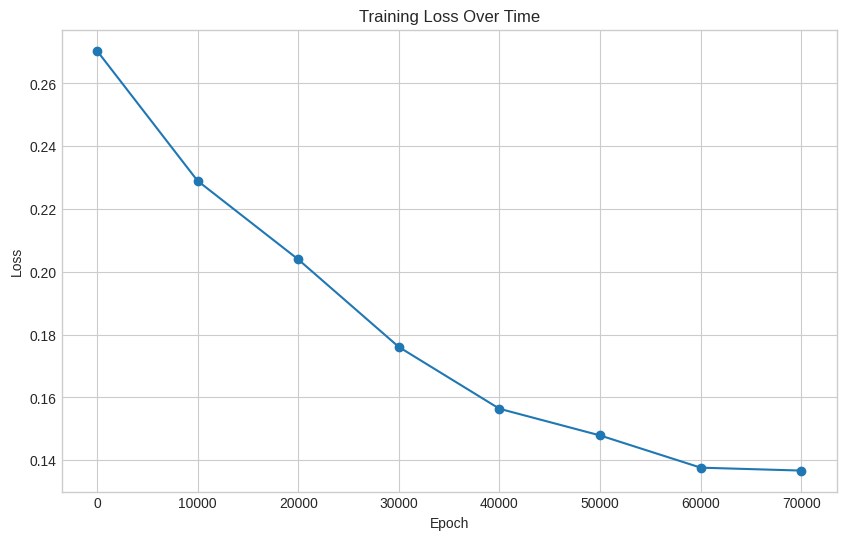

In [17]:
plot_losses(loss, step=step)

## 4.2 Actual vs predicted validation

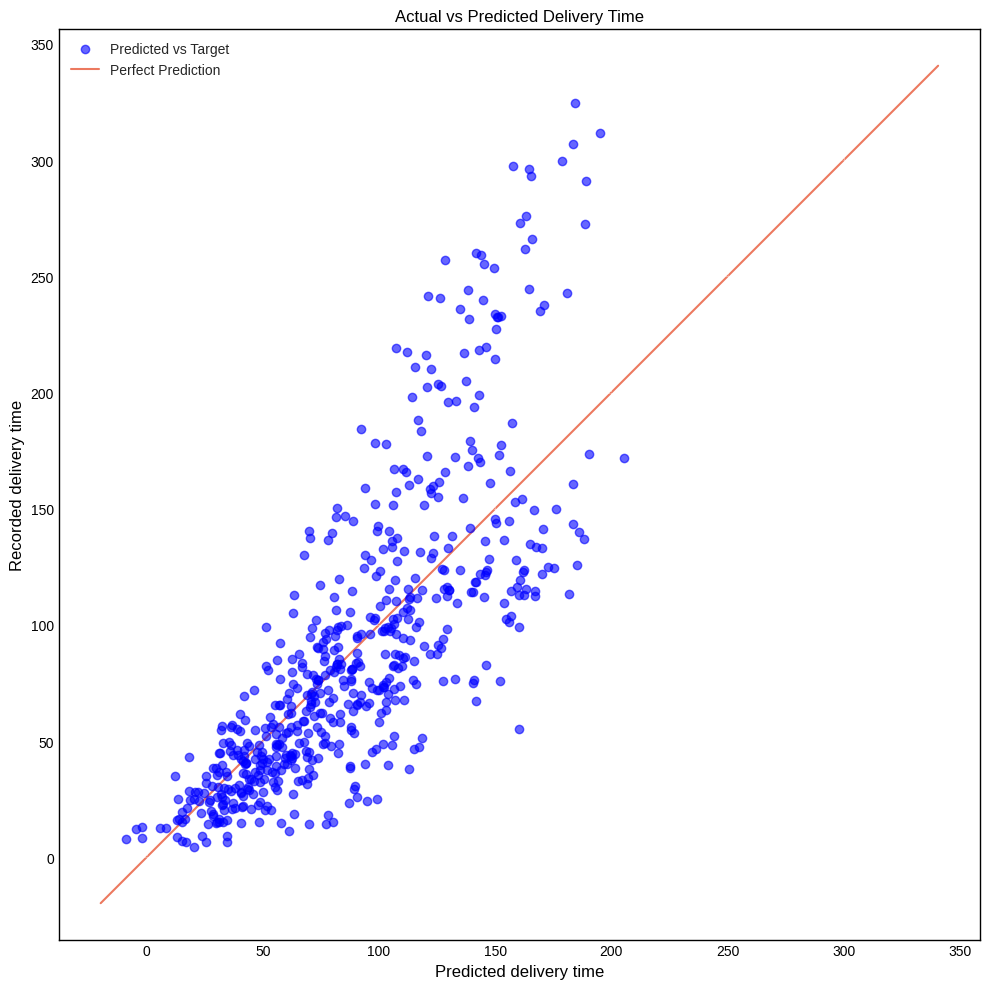

In [19]:
model.eval()
with torch.no_grad():
    predicted_outputs = model(features_selected)

# Denormalize
dist_scaler = results_dict['dist_scaler']
target_scaler = results_dict['target_scaler']
predicted_outputs_denormalized = robust_descale(predicted_outputs.reshape((1, -1)).squeeze(), target_scaler)
targets_denormalized = robust_descale(targets.reshape((1, -1)).squeeze(), target_scaler)
predicted_outputs = predicted_outputs_denormalized

plot_prediction_vs_target(predicted_outputs_denormalized, targets_denormalized)

## 4.3 More plots for various data views

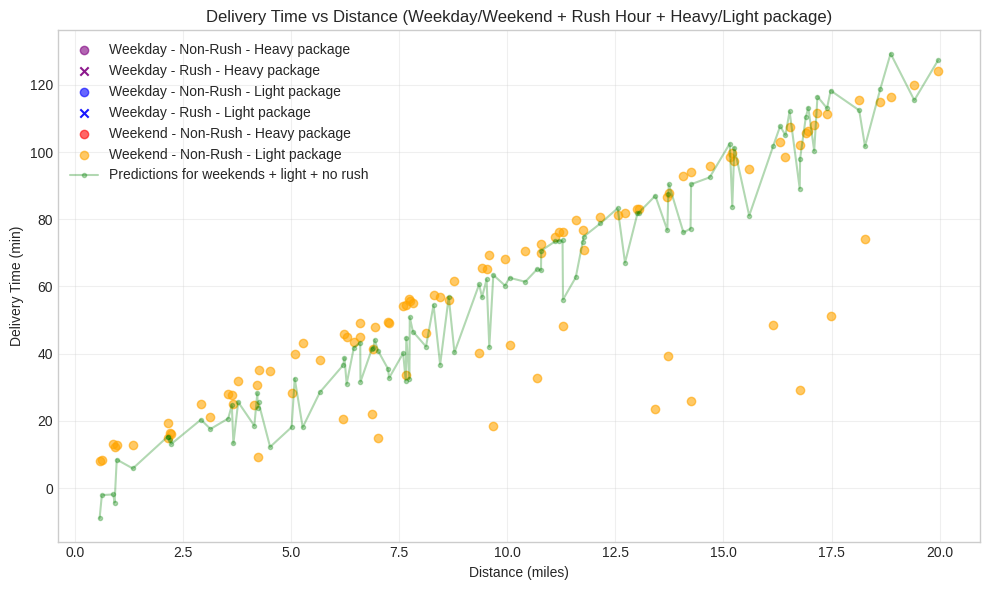

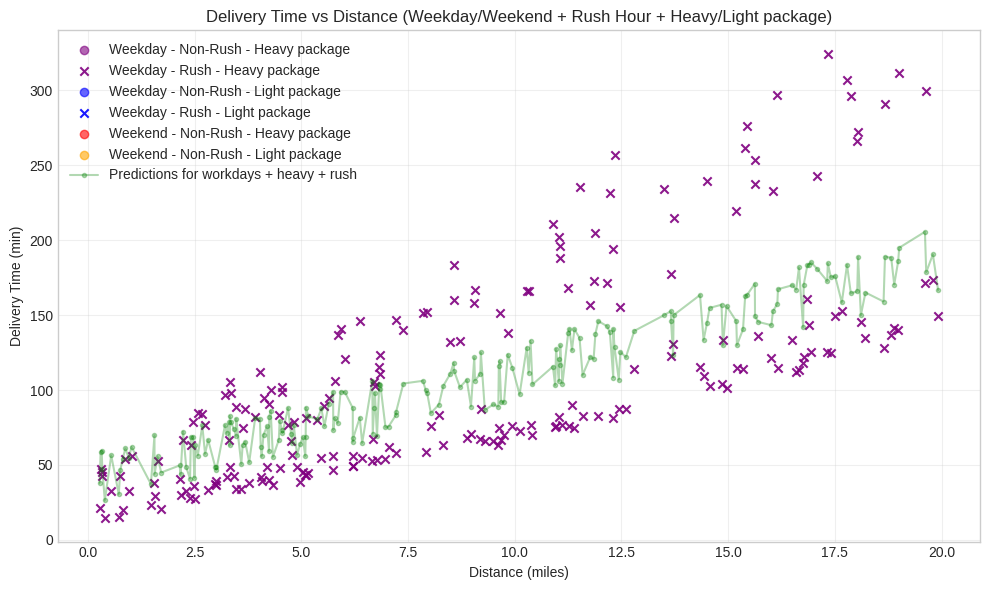

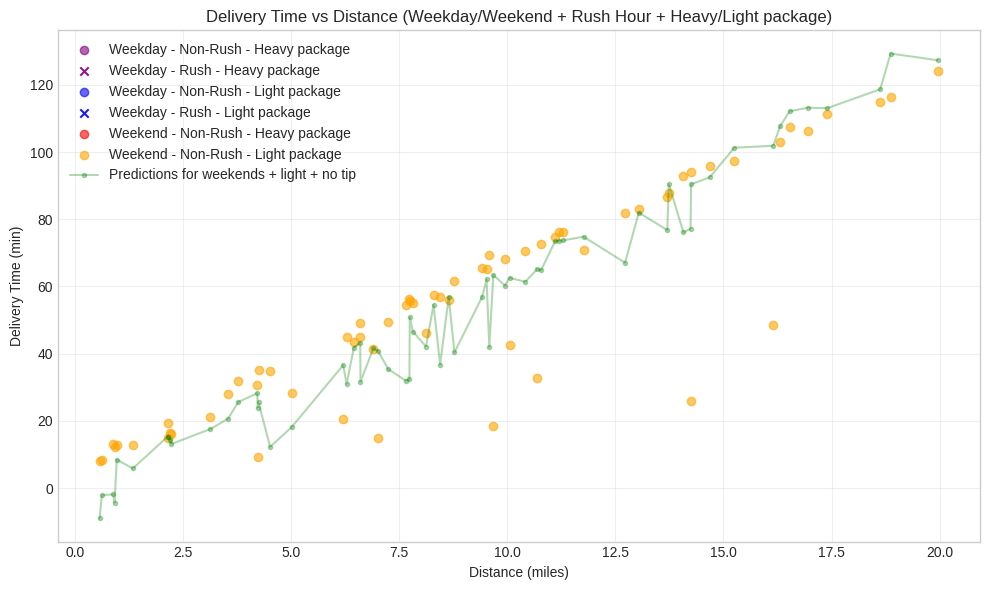

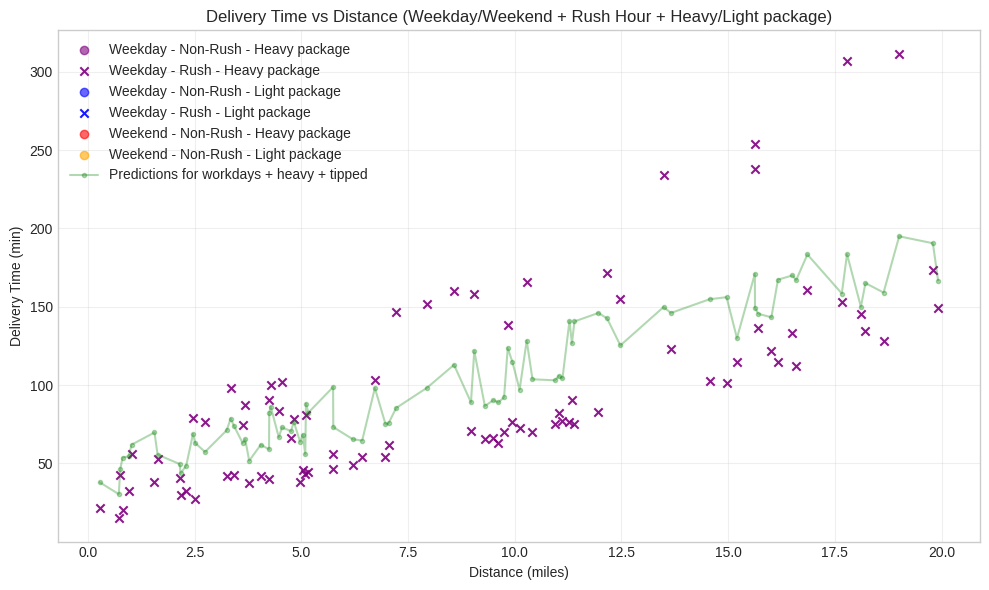

In [20]:
masks1 = [
    (4, "weekends", "workdays"),
]

masks2 = [
    (1, "heavy", "light"),
]

masks3 = [
    (5, "rush", "no rush"),
    (6, "tipped", "no tip")
]

for mask1 in masks1:
    for mask2 in masks2:
        for mask3 in masks3:
            combo_mask = (features[:, mask1[0]] == 1) & (features[:, mask2[0]] == 0) & (features[:, mask3[0]] == 0)
            plot_distance_time_weekday_rush_heavy(
                distance=results_dict['raw_distances'][combo_mask],
                time=results_dict['raw_targets'][combo_mask],
                weekend=results_dict['weekends_col'][combo_mask],
                rush_hour=results_dict['rush_hour_col'][combo_mask],
                heavy_package=results_dict['heavy_package_col'][combo_mask],
                predicted_time=predicted_outputs[combo_mask],
                label=mask1[1] + ' + ' + mask2[2] + ' + ' + mask3[2])
            
            combo_mask = (features[:, mask1[0]] == 0) & (features[:, mask2[0]] == 1) & (features[:, mask3[0]] == 1)
            plot_distance_time_weekday_rush_heavy(
                distance=results_dict['raw_distances'][combo_mask],
                time=results_dict['raw_targets'][combo_mask],
                weekend=results_dict['weekends_col'][combo_mask],
                rush_hour=results_dict['rush_hour_col'][combo_mask],
                heavy_package=results_dict['heavy_package_col'][combo_mask],
                predicted_time=predicted_outputs[combo_mask],
                label=mask1[2] + ' + ' + mask2[1] + ' + ' + mask3[1])


# 5 - New delivery time prediction

In [21]:
def prepare_feature_vector(
    distance_miles,
    package_weight,
    num_of_items,
    delivery_hour,
    is_weekend,
    delivery_tipped,
    results_dict
):
    """
    Converts a pandas DataFrame into prepared PyTorch tensors for modeling.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing the raw delivery data.

    Returns:
        prepared_features (torch.Tensor): The final 2D feature tensor for the model.
        prepared_targets (torch.Tensor): The final 2D target tensor.
        results_dict (dict): A dictionary of intermediate tensors for testing purposes.
    """
    
    # columns:
    # 0 distance_miles,
    # 1 package_weight_lb,
    # 2 num_items,
    # 3 delivery_hour,
    # 4 delivery_on_weekend,
    # 5 delivery_time_min,
    # 6 tip_given

    # 0 scale distance
    # 1 is_heavy_package
    # 2 num of items as is
    # 3 delivery hour as is
    # 4 is weekend as is
    # 5 delivery hour -> is rush hour
    # 6 tip given


    # Filter by distance
    raw_distance = torch.tensor([distance_miles], dtype=torch.float32)
    # raw_weight = torch.tensor(package_weight, dtype=torch.float32)
    raw_num_items = torch.tensor([num_of_items], dtype=torch.float32)
    raw_delivery_hour = torch.tensor([delivery_hour], dtype=torch.float32)
    raw_delivery_on_weekend = torch.tensor([is_weekend], dtype=torch.float32)
    raw_tip_given = torch.tensor([delivery_tipped], dtype=torch.float32)


    # Engineer new simpler features
    is_rush_hour_feature = (raw_delivery_on_weekend == 0 & ((raw_delivery_hour >= 8) & (raw_delivery_hour < 11) | (raw_delivery_hour >= 16) & (raw_delivery_hour < 20))).float()
    is_heavy_feature = torch.tensor([(package_weight > 20)], dtype=torch.float32)

    distance_col = raw_distance.unsqueeze(1)
    num_of_items_col = raw_num_items.unsqueeze(1)
    delivery_hour_col = raw_delivery_hour.unsqueeze(1)
    weekends_col = raw_delivery_on_weekend.unsqueeze(1)
    rush_hour_col = is_rush_hour_feature.unsqueeze(1)
    heavy_package_col = is_heavy_feature.unsqueeze(1)
    tipped_col = raw_tip_given.unsqueeze(1)

    # Normalize continuous and large feature columns
    dist_scaled = apply_robust_scale(distance_col, results_dict['dist_scaler'])
    # target_scaled = apply_robust_scale(results_dict.target_scaler)
    
    distance_norm = dist_scaled
    # targets_norm = target_scaled.unsqueeze(1)
    
    
    # dist_mean, dist_std = distances_col.mean(), distances_col.std()
    # targets_mean, targets_std = targets_col.mean(), targets_col.std()
    hours_mean, hours_std = results_dict['hours_col'].mean(), results_dict['hours_col'].std()
    num_items_mean, num_items_std = results_dict['num_items_col'].mean(), results_dict['num_items_col'].std()
 

    delivery_hour_norm = (delivery_hour_col - hours_mean) / hours_std
    num_items_norm = (num_of_items_col - num_items_mean) / num_items_std

    # print(distance_norm.shape)
    # print(heavy_package_col.shape)
    # print(num_items_norm.shape)
    # print(delivery_hour_norm.shape)
    # print(weekends_col.shape)
    # print(rush_hour_col.shape)
    # print(tipped_col.shape)

    # Combine all
    prepared_features = torch.cat([
        distance_norm,
        heavy_package_col,
        num_items_norm,
        delivery_hour_norm,
        weekends_col,
        rush_hour_col,
        tipped_col
    ], dim=1)

    return prepared_features

### Predict time - case 1: short distance, workday, light package

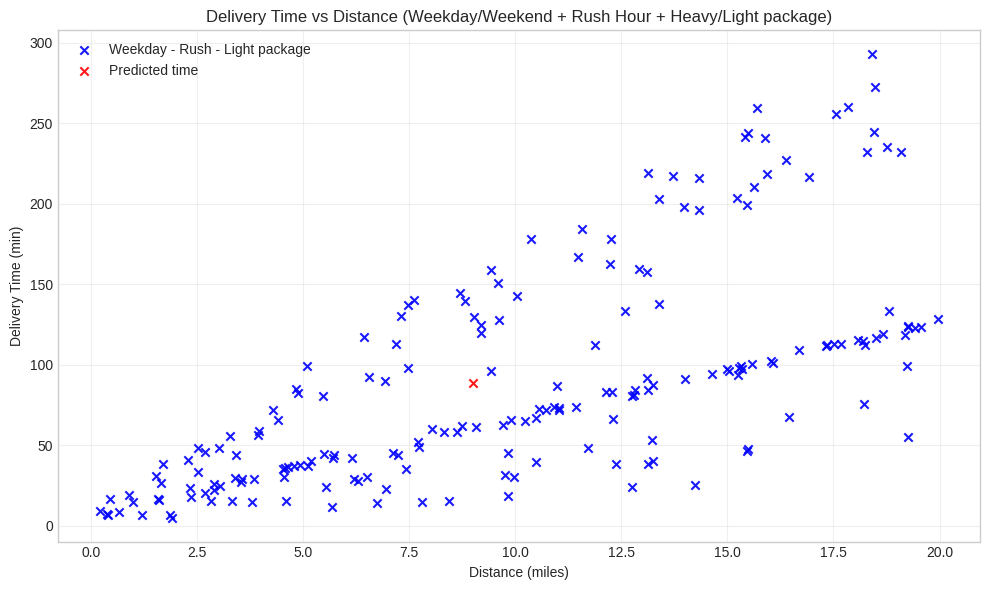

In [22]:
delivery_condition = prepare_feature_vector(
    distance_miles = 9,
    package_weight = 8,
    num_of_items = 3,
    delivery_hour = 16,
    is_weekend = False,
    delivery_tipped = True,
    results_dict = results_dict
)

delivery_condition = delivery_condition[:, [0, 1, 3, 5]]

with torch.no_grad():
    predicted_time = model(delivery_condition)

# Denormalize
target_scaler = results_dict['target_scaler']
predicted_time_denormalized = robust_descale(predicted_time.reshape((1, -1)).squeeze(), target_scaler)
predicted_time = predicted_time_denormalized

plot_predicted_time_rush_light(results_dict=results_dict, predicted_point=(9, predicted_time))

### Predict time - case 2: long distance, weekend, heavy package

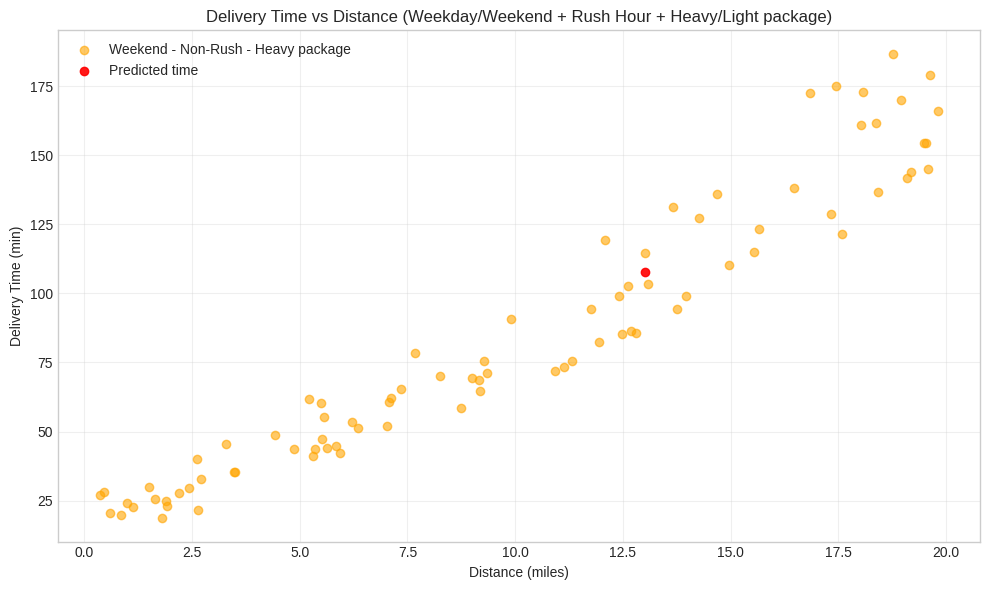

In [23]:
delivery_condition = prepare_feature_vector(
    distance_miles = 13,
    package_weight = 25,
    num_of_items = 3,
    delivery_hour = 13,
    is_weekend = True,
    delivery_tipped = True,
    results_dict = results_dict
)

delivery_condition = delivery_condition[:, [0, 1, 3, 5]]

with torch.no_grad():
    predicted_time = model(delivery_condition)

# Denormalize
target_scaler = results_dict['target_scaler']
predicted_time_denormalized = robust_descale(predicted_time.reshape((1, -1)).squeeze(), target_scaler)
predicted_time = predicted_time_denormalized

plot_predicted_time_norush_heavy(results_dict=results_dict, predicted_point=(13, predicted_time))

### Predict time - case 3: short distance, workday, rush hour, heavy package

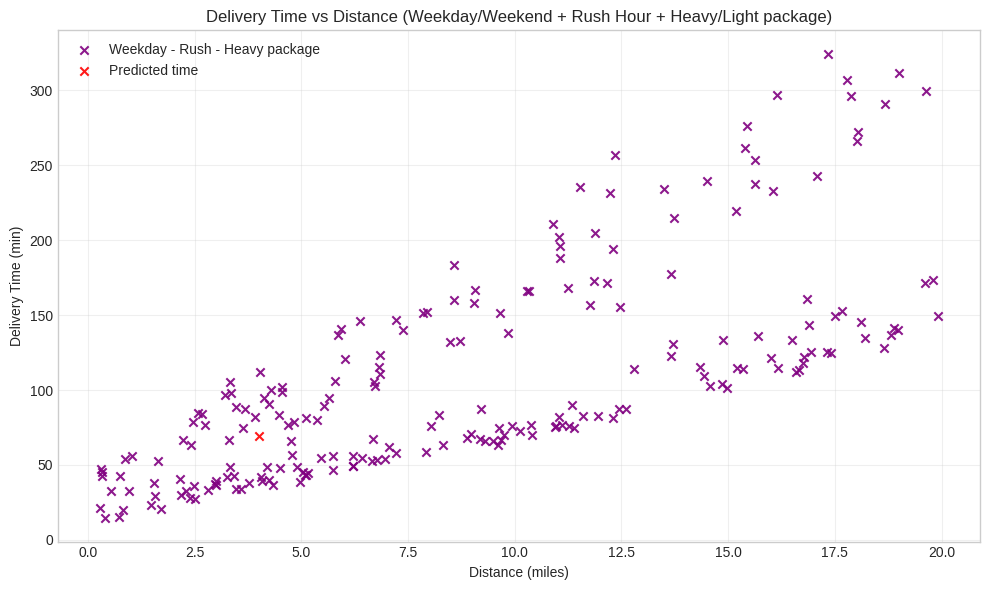

In [24]:
delivery_condition = prepare_feature_vector(
    distance_miles = 4,
    package_weight = 50,
    num_of_items = 3,
    delivery_hour = 10,
    is_weekend = False,
    delivery_tipped = True,
    results_dict = results_dict
)

delivery_condition = delivery_condition[:, [0, 1, 3, 5]]

with torch.no_grad():
    predicted_time = model(delivery_condition)

# Denormalize
target_scaler = results_dict['target_scaler']
predicted_time_denormalized = robust_descale(predicted_time.reshape((1, -1)).squeeze(), target_scaler)
predicted_time = predicted_time_denormalized

plot_predicted_time_rush_heavy(results_dict=results_dict, predicted_point=(4, predicted_time))